In [1]:
%env THEANO_FLAGS=device=cuda0
%matplotlib inline

env: THEANO_FLAGS=device=cuda0


In [2]:
import sys
sys.path.append("..")

In [3]:
from lib.util import pics2array
import os
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = "/home/deniska/Projects/cycle/datasets/notMNIST_large/"

a_names = os.listdir(DATA_PATH + "A/")
c_names = os.listdir(DATA_PATH + "B/")

As = list()
for name in a_names:
    try:
        As.append(pics2array(DATA_PATH + "A/", [name], im_size=(32, 32)))
    except:
        pass
As = np.array(As)/255.

Bs = list()
for name in c_names:
    try:
        Bs.append(pics2array(DATA_PATH + "B/", [name], im_size=(32, 32)))
    except:
        pass
Bs = np.array(Bs)/255.

In [4]:
from lib.zoo import UnetGenerator, Discriminator
from lasagne.layers import get_output

# G(a) -> b_hat & F(b) -> a_hat
genA2B = UnetGenerator(input_dim=(32, 32))
genB2A = UnetGenerator(input_dim=(32, 32))

# kind of a bodge
realA = genA2B.input_var
realB = genB2A.input_var

# D_a(F(b)) & D_b(G(a))
discA = Discriminator(genB2A, wasserstein=True, real_inp_var=realA)
discB = Discriminator(genA2B, wasserstein=True, real_inp_var=realB)

# F(G(a)) -> a_cyc & G(F(b)) -> b_cyc
cycleA = get_output(genB2A.model["output"], genA2B.output_var)
cycleB = get_output(genA2B.model["output"], genB2A.output_var)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_aPb28f.c:4:19: fatal error: cudnn.h: Нет такого файла или каталога
compilation terminated.

Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [5]:
# low learning rate for debugging purpose, use a higher one
ADAM_PARAMS = {"learning_rate" : 1e-5, "beta1" : 0.5, "beta2" : 0.9}
CYCLE_LAMBDA = 10

In [6]:
import theano
import theano.tensor as T
from lib.losses import wasserstein_gradient_penalty_loss
from lasagne.updates import adam

disc_a_loss = wasserstein_gradient_penalty_loss(realA, genB2A.output_var, discA.model["out"])
disc_b_loss = wasserstein_gradient_penalty_loss(realB, genA2B.output_var, discB.model["out"])

combined_disc_loss = disc_a_loss + disc_b_loss

cycle_loss = (T.abs_(realA - cycleA) + T.abs_(realB - cycleB)).mean()

gen_a_loss = -discA.fake_out.mean()
gen_b_loss = -discB.fake_out.mean()

combined_gen_loss = gen_a_loss + gen_b_loss + CYCLE_LAMBDA * cycle_loss

disc_updates = adam(combined_disc_loss, discA.params + discB.params, **ADAM_PARAMS)
gen_updates = adam(combined_gen_loss, genA2B.params + genB2A.params, **ADAM_PARAMS)

train_disc = theano.function([realA, realB], combined_disc_loss, updates=disc_updates)
train_gen = theano.function([realA, realB], combined_gen_loss, updates=gen_updates)

In [7]:
def sample_batch(size=16, x=As, y=Bs):
    ixes = np.random.randint(0, len(As), size=size)
    
    # non-pair data, so we can apply the same indexes
    return x[ixes], y[ixes]

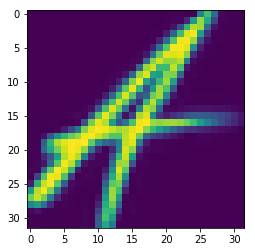

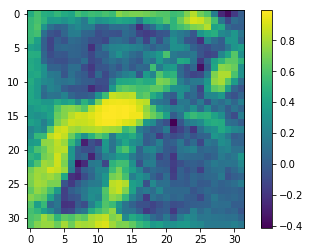

1361
1362
1363
1364


KeyboardInterrupt: 

In [28]:
from IPython.display import clear_output

n_epochs = 2000
batch_size = 8

display_epoch = 10

n_critic = 4

for ep in range(n_epochs):
    print ep
    
    for _ in range(n_critic):
        x, y = sample_batch(8)
        
        train_disc(x, y)
        
    x, y = sample_batch(8)
    
    train_gen(x, y)
    
    if ep % display_epoch == 0:
        clear_output()
        
        image = genA2B.generate(x)
        
        plt.imshow(x[0, 0])
        plt.show()
        
        plt.imshow(image[0, 0])
        plt.colorbar()
        plt.show()

In [32]:
import pickle
from lasagne.layers import get_all_param_values

with open("../weights/letter-cycle-gan/a2b.pcl", "wb") as f:
    pickle.dump(get_all_param_values(genA2B.model["output"]), f)
    
with open("../weights/letter-cycle-gan/a2b.pcl", "wb") as f:
    pickle.dump(get_all_param_values(genA2B.model["output"]), f)
    
with open("../weights/letter-cycle-gan/disc_a.pcl", "wb") as f:
    pickle.dump(get_all_param_values(discA.model["out"]), f)
    
with open("../weights/letter-cycle-gan/disc_b.pcl", "wb") as f:
    pickle.dump(get_all_param_values(discB.model["out"]), f)    